# Проект DonorSearch Reports Rotation

### Введение
Заказчик - DonorSearch -  занимается развитием донорства в стране. Для этого есть платформа DonorSearch.org - где для доноров доступны бонусная программа, игрофикация пути донора и многое другое. Важной является проверка честности доноров и корректности внесенных донаций. Подтверждение производится по справке установленной формы (№405), такую справку донор получает в центре крови.

### Задачи проекта
- Исследовать существующие подходы к решению задачи;
- Выбор готовой или обучение собственной модели компьютерного зрения для определения ориентации изображения;
- Подготовка скриптов для препроцессинга изображения, инференса модели и постпроцессинга изображения;
- Тестирование модели, определение метрик;
- Создание микросервиса для последующей интеграции в продукт заказчика.


### Исходные данные
Набор изображений в разной ориентации. Имеются целевые фотографии справок, а так же дополнительные.


### Требования

- Рассчитана Accuracy для многоклассовой классификации;
- Построены ROC-кривые и матрицы ошибок для наилучшей из моделей;
- Формат входных данных - путь к изображению;
- Формат выходных данных - np.array или Pillow.Image (либи любой другой вариант, итоговый вариант озвучит заказчик);
- Количество классов классификатора - 4 (поворот на 0, 90, 180 или 270 градусов);
- Инференс - на CPU.

## Исследование подходов к решению задачи

Задача — автоматически определять угол поворота изображения (0°, 90°, 180°, 270°) и корректировать ориентацию перед следующим шагом в продекте заказчика. Основные подходы по определению ориентации:

### Традиционные методы компьютерного зрения

**SIFT, SURF, ORB (фичерные методы)**
- Методы извлечения ключевых точек могут использоваться для нахождения повторяющихся элементов на изображении. Это подходит, если на справке присутствуют узнаваемые символы или логотипы, которые помогут определить правильное положение.
- Преимущества: простота и относительная скорость выполнения.
- Недостатки: чувствительность к качеству изображения, шумам и деформациям.

**Hough Transform**
- Преобразование Хафа часто используется для поиска линий и углов. Можно использовать для обнаружения горизонтальных и вертикальных линий на документе и корректировки его ориентации.
- Преимущества: устойчивость к шумам.
- Недостатки: сложно применить к сложным документам или документам с множеством элементов.

### Методы, основанные на глубоких нейронных сетях (DNN)

**ResNet, EfficientNet, Vision Transformer (ViT)**
- Современные глубокие сети могут быть обучены для предсказания угла поворота изображения. Можно настроить модель на классификацию углов поворота (0°, 90°, 180°, 270°).
- Преимущества: высокое качество предсказаний на сложных данных, возможность использования предобученных моделей.
- Недостатки: требуется большой объем данных для обучения, высокая вычислительная стоимость.

### Предобученные модели глубоких нейронных сетей с дообучением на исходных данных

- Использование предобученных моделей, таких как ResNet, EfficientNet, ViT, может значительно ускорить процесс разработки. Если доступны датасеты с подобными медицинскими справками, они могут быть использованы для дообучения.
- Преимущества: меньшие затраты на обучение, более быстрое внедрение.
- Недостатки: могут быть не адаптированы под специфические задачи и данные.

### Способ повысить производительность

**Аугментация изображений**

Для повышения производительности модели можно использовать:

- Повороты на случайные углы.
- Изменения яркости, контраста, шума (чтобы имитировать разные условия съемки справок).
- Кроппинг и масштабирование изображений.

**Вывод:**
Для решения поставленной задачи будет использована комбинация методов глубокого обучения с предобученными моделями, такими как ResNet или EfficientNet, с применением аугментации. Это обеспечит высокую точность в условиях ограниченного объема данных и разнообразных изображений справок.

## Подготовка данных

Загружаем необходимые библиотеки

In [1]:
# Стандартные библиотеки
import time
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle

# Вспомогательные библиотеки
from tqdm import tqdm
from PIL import Image

# Библиотеки для оценки метрик sklearn
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize



# Библиотеки глубокого обучения нейросетей
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import v2
from torchvision import models
from torchvision.datasets import ImageFolder

# Исходные константы
# Классы поворота: 0, 90, 180, 270 градусов
NUM_CLASSES = 4
# Директория с изображениями
IMAGE_DIR = 'src/data/image/transformed'
# Размер пачки тензоров
BATCH_SIZE = 32

Исходные изображения состоят из фотографий целевых и нецелевых справок. В проекте не стоит задача определения целевой справки. Для обучения определения ориентации изображения подойдут любые справки. 

Так как количество изображений ограничено 173 единицами, принято решение все изображения привести к нормальной ориентации и аугментировать поворотом на 90, 180 и 270 градусов. Таким образом количество изображений увеличится в 4 раза, что все равно недостаточно для качественного обучения нейронной сети. Для поворота изображений используем следующую функцию.

In [2]:
# Подготовка данных с поворотами
def prepare_rotated_dataset(image_dir: str, need_create: bool) -> str:
    """
    Подготавливает набор данных с изображениями, повернутыми на различные углы, и сохраняет их в отдельные папки по классам.

    :param image_dir: str
        Путь к директории с исходными изображениями, которые будут поворачиваться.
    
    :return: str
        Путь к директории, содержащей папки с повернутыми изображениями, где каждая папка соответствует углу поворота (0°, 90°, 180°, 270°).
    
    Описание:
    1. Создает директорию 'transformed' внутри исходной директории для хранения повернутых изображений.
    2. Для каждого угла поворота (0°, 90°, 180°, 270°) создает отдельную папку.
    3. Перебирает все изображения в исходной директории (с расширениями .jpg и .png).
    4. Выполняет поворот изображения на указанный угол и сохраняет его в соответствующей папке.
    
    Классы поворотов:
    - 0: Нет поворота (0°).
    - 1: Поворот на 90°.
    - 2: Поворот на 180°.
    - 3: Поворот на 270°.

    Пример использования:
    ```
    prepare_rotated_dataset('/path/to/images')
    ```
    """    

    transformed_dir = os.path.join(image_dir, 'transformed')

    if not need_create:
        return "Изображения уже подготовлены"
    
    os.makedirs(transformed_dir, exist_ok=True)

    classes = [0, 1, 2, 3]  # 0 - нет поворота, 1 - 90 градусов, 2 - 180 градусов, 3 - 270 градусов
    angles = [0, 90, 180, 270]

    for class_id, angle in zip(classes, angles):
        class_dir = os.path.join(transformed_dir, str(class_id))
        os.makedirs(class_dir, exist_ok=True)
        for filename in os.listdir(image_dir):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                img_path = os.path.join(image_dir, filename)
                img = Image.open(img_path)
                rotated_img = rotate_image(img, angle)
                rotated_img.save(os.path.join(class_dir, f'{class_id}_{filename}'))

    return transformed_dir

# Преобразование изображений с поворотом
def rotate_image(image, angle):
    return image.rotate(angle)

In [3]:
prepare_rotated_dataset(IMAGE_DIR, need_create=False)

'Изображения уже подготовлены'

Для корректной загрузки данных в модель необходимо выполнить подготовку изображений. В модель поступают данные в виде тензоров. Модель легко работает с "пачкой" тензоров. 

Во время подготовки необходимо учитывать, что изображения для тренировки должны быть предобработанны аналогично как и тестовые.

Библиотека torch позволяет аугменитровать изображения на этапе трансформации. Например, можно добавить случайный поворот изображения на +-15 градусов и горизонтальное отражение. Так же имеется возможность изменение цвета, гауссовское размытие, изменение размера и тд, но данные изменения не носят случайный характер.

Для тестовой трансформации уберем преобразования, носящие случайный характер. В остальном предобработка должна соответствовать тренировочной.

In [4]:
# Определяем трансформации для предобработки
train_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.RandomRotation(degrees=(-15, 15)),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.uint8, scale=True),
    v2.Resize((224, 224)),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Для удобства загрузки изображений воспользуемся DataLoader. Он разделит датасет на пачки и перемешает изображения.

In [5]:
# Загрузка данных с тренировочными трансформациями
train_dataset = ImageFolder(root=IMAGE_DIR, transform=train_transforms)

# Для валидации и теста применяются тестовые трансформации
val_dataset = ImageFolder(root=IMAGE_DIR, transform=test_transforms)
test_dataset = ImageFolder(root=IMAGE_DIR, transform=test_transforms)

# Разделение на тренировочные, валидационные и тестовые данные
train_size = int(0.7 * len(train_dataset))
val_size = (len(train_dataset) - train_size) // 2
test_size = len(train_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(train_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

**Вывод:**
Подготовлены изображения для обучения, каждый класс находится в своей папке. Все изображения проходят предварительную трансформацию в пачку тензоров. Для удобства подачи тензоров в модель используется DataLoader. 
На каждой эпохе происходит случайное изменение угла поворота изображения на 15 градусов и случайное отражение по вертикали. Такой подход позволит "на лету" полочить дополнительную аугментацию изображений, что улучшит обучение моделей.

### Подготовка скриптов для моделей

Кратко про используемые в проекте нейронные сети:

1. **ResNet (ResNet18 и ResNet34)**

ResNet (Residual Networks) были предложены исследователями Microsoft Research и сделали революцию в области глубокого обучения, когда речь заходит о тренировке очень глубоких нейронных сетей. Главная особенность ResNet — это остаточные соединения, которые помогают избежать проблемы исчезающего градиента и позволяют эффективно обучать сети с очень большим количеством слоев.

ResNet18: модель с 18 слоями. Это легкая и быстрая модель, которая может быть полезна для небольших или менее сложных задач, таких как предсказание ориентации. Она требует меньше вычислительных ресурсов и может быть использована для быстрой тренировки или предсказания на устройствах с ограниченными ресурсами.

ResNet34: модель с 34 слоями. Она обладает большей глубиной по сравнению с ResNet18 и может извлекать более сложные признаки с изображений. Эта модель обычно используется для более точных прогнозов и в ситуациях, когда требуется повысить производительность за счет более сложных паттернов в данных.

Преимущества ResNet:

- Эффективна на более глубоких сетях благодаря residual connections.
- Хорошо подходит для различных задач классификации изображений.
- Легко дообучаема на небольших наборах данных.

2. **EfficientNet_B0**

EfficientNet — это семейство моделей, представленное в 2019 году компанией Google. Эти модели известны своим сбалансированным подходом к увеличению точности при минимизации вычислительных ресурсов. EfficientNet_B0 — это базовая версия EfficientNet, которая использует инновационный подход к масштабированию глубины, ширины и разрешения сети.

Особенности EfficientNet:

- Комплексное масштабирование: В большинстве моделей увеличение производительности достигается за счет увеличения либо глубины (больше слоев), либо ширины (больше каналов), либо разрешения входного изображения. EfficientNet использует новый подход — compound scaling — который позволяет эффективно масштабировать все три аспекта (глубина, ширина и разрешение) одновременно, что помогает сохранить баланс между сложностью модели и точностью предсказаний.

- Базовая архитектура: EfficientNet использует блоки Inverted Bottleneck, вдохновленные MobileNetV2, и расширяет их с использованием слоев сверток с групповыми нормализациями. Это делает модель легкой и быстрой, но при этом достаточно мощной для сложных задач.

- Эффективность: По сравнению с ResNet и другими архитектурами, EfficientNet достигает лучшей точности при меньшем количестве параметров и операциях с плавающей точкой. Это делает модель особенно привлекательной для мобильных и встроенных устройств, где ресурсы ограничены.

3. **MobileNet V3**


MobileNet V3 — это улучшение предыдущих версий MobileNet (V1 и V2) и использует несколько инноваций для повышения эффективности:

- Свертки с разделением на глубину (depthwise separable convolutions) — разбиение стандартной свертки на две: глубинную свертку и точечную свертку (pointwise), что значительно уменьшает количество параметров и операций.
- Squeeze-and-Excitation (SE) блоки — эти блоки динамически взвешивают каналы, усиливая важные и подавляя несущественные.
- Non-linear Activation Function (h-swish) — активационная функция h-swish (hard swish) заменяет стандартную ReLU для повышения эффективности.
- Light-weight Attention — attention-механизмы для улучшения производительности.

Плюсы:

- Высокая эффективность для мобильных устройств: Благодаря упрощенной архитектуре, MobileNet V3 идеально подходит для использования в приложениях с ограниченными вычислительными ресурсами.
- Низкое потребление памяти: Модель требует меньших объемов памяти, что особенно важно для устройств с малым объемом RAM.
- Оптимизация под устройства: Прекрасно работает на мобильных устройствах благодаря глубокой оптимизации под ARM-архитектуру.
- Высокая производительность при малом количестве параметров: MobileNet V3 поддерживает разумный баланс между количеством параметров и качеством предсказаний.

Минусы:

- Ограниченная производительность на сложных задачах: В случае задач с высокими требованиями к точности MobileNet V3 может уступать более мощным моделям, таким как EfficientNet.
- Меньше возможностей для масштабирования: Ограничена масштабируемость модели, поскольку она ориентирована на мобильные и легкие применения.


4. **ShuffleNet V2**

ShuffleNet V2 предложен как оптимизация предыдущей версии и включает ключевые принципы для повышения эффективности:

- Channel Shuffle — основная инновация архитектуры заключается в смешивании каналов между группами после групповой свертки, что позволяет улучшить взаимодействие информации между каналами;
- Grouped Convolutions — с использованием групповой свертки для уменьшения вычислительной сложности, разделяя фильтры на группы;
- Balanced Computation — архитектура разработана так, чтобы обеспечить баланс вычислительной нагрузки между различными слоями.

Плюсы:

- Высокая скорость вычислений: ShuffleNet V2 обладает очень низкой вычислительной сложностью, что делает его подходящим для реального времени и мобильных приложений.
- Эффективное использование ресурсов: Модель сбалансирована для оптимального использования памяти и вычислительных мощностей.
- Хорошая производительность при низкой сложности: Несмотря на простоту архитектуры, модель демонстрирует хорошую производительность на задачах классификации изображений.

Минусы:

- Потеря точности при слишком малом числе параметров: При значительном уменьшении параметров может пострадать качество предсказаний.
- Меньшая гибкость: Модель менее гибкая и масштабируемая по сравнению с такими архитектурами, как ResNet и EfficientNet.


**Заключение:**
- ResNet18 — легкая и быстрая популярная модель для задач компьютерного зрения, хорошо подходит для базовых классификационных задач с небольшими ресурсами;
- ResNet34 — более тяжелая модель семейства ResNet с увеличенной глубиной, что позволяет достигать более высокой точности при классификации;
- EfficientNet_B0 — эффективная альтернатива ResNet, оптимизированная для хороших результатов на слабых ресурсах за счет использования масштабируемой архитектуры;
- MobileNet V3 — прекрасно подходит для мобильных устройств благодаря глубокой оптимизации под ARM-архитектуру, сохраняя баланс между точностью и эффективностью;
- ShuffleNet V2 — легкая модель, использующая принципы Channel Shuffle и Grouped Convolutions, отлично подходит для встроенных систем и мобильных приложений.


Так как в ТЗ не указано, на каком типе устройства производить обучение, выполним на имеющемся GPU. Таким образом, можно ускорить инференс моделей в 6-10 раз. Настроим устройство.

In [6]:
# Настройки устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce GTX 1650


Загрузим каждую из моделей и поменяем последний слой для предсказания 4 классов.

In [8]:
def get_resnet18_model(num_classes: int=NUM_CLASSES) -> torch.nn.Module:
    """
    Создает и возвращает модель ResNet18 с предобученными весами на ImageNet и измененным выходным слоем.

    :param num_classes: int - количество классов для классификации (по умолчанию NUM_CLASSES).
    
    :return: torch.nn.Module - модель ResNet18 с измененным последним слоем под необходимое количество классов.
    """

    model = models.resnet18(weights='IMAGENET1K_V1')  # Загрузка предобученной ResNet34
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Замена последнего слоя
    print('Model resnet18 ready!')
    return model.to(device)


def get_resnet34_model(num_classes: int=NUM_CLASSES) -> torch.nn.Module:
    """
    Создает и возвращает модель ResNet34 с предобученными весами на ImageNet и измененным выходным слоем.

    :param num_classes: int - количество классов для классификации (по умолчанию NUM_CLASSES).
    
    :return: torch.nn.Module - модель ResNet34 с измененным последним слоем под необходимое количество классов.
    """

    model = models.resnet34(weights='IMAGENET1K_V1')  # Загрузка предобученной ResNet34
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Замена последнего слоя
    print('Model resnet34 ready!')
    return model.to(device)


def get_efficientnet_model(num_classes: int=NUM_CLASSES) -> torch.nn.Module:
    """
    Создает и возвращает модель EfficientNet-B0 с предобученными весами и измененным выходным классификатором.

    :param num_classes: int - количество классов для классификации (по умолчанию NUM_CLASSES).
    
    :return: torch.nn.Module - модель EfficientNet-B0 с измененным классификатором под необходимое количество классов.
    """
    
    model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')  # EfficientNet-b0
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)  # Замена финального классификатора
    print('Model efficientnet_b0 ready!')
    return model.to(device)


def get_mobilenet_v3_model(num_classes: int = NUM_CLASSES) -> torch.nn.Module:
    """
    Создает и возвращает модель MobileNet_V3_Large с предобученными весами и измененным выходным классификатором.

    :param num_classes: int - количество классов для классификации (по умолчанию NUM_CLASSES).
    
    :return: torch.nn.Module - модель MobileNet_V3_Large с измененным классификатором под необходимое количество классов.
    """
    
    model = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2)  # MobileNet_V3_Large
    model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)  # Замена финального классификатора
    print('Model mobilenet_v3 ready!')
    return model.to(device)


def get_shufflenet_v2_model(num_classes: int = NUM_CLASSES) -> torch.nn.Module:
    """
    Создает и возвращает модель ShuffleNet_V2 с предобученными весами и измененным выходным классификатором.

    :param num_classes: int - количество классов для классификации (по умолчанию NUM_CLASSES).
    
    :return: torch.nn.Module - модель ShuffleNet_V2 с измененным классификатором под необходимое количество классов.
    """
    
    model = models.shufflenet_v2_x2_0(weights=models.ShuffleNet_V2_X2_0_Weights.IMAGENET1K_V1)  # ShuffleNet_V2
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Замена финального классификатора
    print('Model shufflenet_v2 ready!')
    return model.to(device)


После подготовки инициализации предобученных моделей, необходимо подготовить скрипты для тренировки, валидации и тестирования моделей на датасетах. Для моделей будем использовать оптимизатор Адам и планировщик градиентного CosineAnnealingLR. Функция потерь -  CrossEntropyLoss.

Для каждого прогона теста модели посчитаем среднее время загрузки картинки и среднее время предсказания. В качестве целевой метрики используем Accuracy. На выходе получим график с паказетелями метрики во время тренировки и предсказания.

In [9]:
# Функция для обучения модели
def train_model(model:torch.nn.Module, 
                train_loader: torch.utils.data.dataloader.DataLoader, 
                val_loader: torch.utils.data.dataloader.DataLoader, 
                device: torch.device, 
                num_epochs: int=20):
    """
    Обучает модель на тренировочных данных и проводит валидацию на каждом шаге.

    :param model: torch.nn.Module - модель для обучения.
    :param train_loader: torch.utils.data.DataLoader - DataLoader для тренировочных данных.
    :param val_loader: torch.utils.data.DataLoader - DataLoader для валидационных данных.
    :param device: torch.device - устройство для выполнения вычислений (CPU или GPU).
    :param num_epochs: int - количество эпох для обучения (по умолчанию 20).

    Функция для тренировки модели нейросети. 

    Используется:
    Функция потерь - CrossEntropyLoss
    Оптимизатор - Adam
    Планировщик градиентного шага - CosineAnnealingLR

    Функция каждые 5 эпох выводит результат и проводит тестирование на валидационном датасете. 
    Так же выводит среднее время загрузки данных и инференса на одну картинку.
    
    :return: None
    """
    time_loaded = []
    time_inference = []
    train_results = []
    validation_results = {}

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.003)
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0.0001)
    model.train()
    for epoch in tqdm(range(num_epochs)):

        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for batch in train_loader:

            timepoint_1 = time.time()

            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            timepoint_2 = time.time()
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)
            timepoint_3 = time.time()

            time_loaded.append(timepoint_2-timepoint_1)
            time_inference.append(timepoint_3-timepoint_2)


        # Обновление scheduler
        scheduler.step()
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_accuracy = correct_predictions / total_predictions     
        train_results.append(epoch_accuracy)
        
        if epoch%5 == 0 or epoch == num_epochs - 1:
            print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')
            print(f"Data loading time per image: {(sum(time_loaded)/(epoch+1)/BATCH_SIZE):.4f} seconds")
            print(f"Inference time per image: {(sum(time_inference)/(epoch+1)/BATCH_SIZE):.4f} seconds")

            # Валидация после каждой эпохи
            validation_results[epoch+1] = validate_model(model, val_loader, device)

    # Построение графика точности
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_results) + 1), train_results, label='Тренировочная Accuracy')
    plt.plot(validation_results.keys(), validation_results.values(), label='Валидационная Accuracy')
    plt.xlabel('Эпохи')
    plt.ylabel('Accuracy')
    plt.title('График изменения тренировочной и валидационной Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


    


# Функция для валидации модели
def validate_model(model:torch.nn.Module, 
                   val_loader: torch.utils.data.dataloader.DataLoader, 
                   device: torch.device):
    """
    Выполняет валидацию модели на предоставленных данных, выводя потери и точность.

    :param model: torch.nn.Module - модель для валидации.
    :param val_loader: torch.utils.data.DataLoader - загрузчик данных для валидации.
    :param device: torch.device - устройство для выполнения вычислений (CPU или GPU).

    Выводит потери (loss) и точность (accuracy) на валидационном наборе данных.
    """

    criterion = nn.CrossEntropyLoss()
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in val_loader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_predictions / total_predictions
    print(f'Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')
    model.train()

    return val_accuracy

def testing_model(model:torch.nn.Module, 
                  test_loader: torch.utils.data.dataloader.DataLoader, 
                  device: torch.device):
    """
    Тестирует модель на тестовом наборе данных, вычисляет потери, точность и собирает предсказания и вероятности для анализа.

    :param model: torch.nn.Module - модель для тестирования.
    :param test_loader: torch.utils.data.DataLoader - загрузчик данных для тестирования.
    :param device: torch.device - устройство для выполнения вычислений (CPU или GPU).

    :return: tuple(np.array, np.array, np.array) - кортеж, содержащий истинные метки, предсказанные метки и вероятности для каждого класса.
    
    Также выводит потери и точность на тестовом наборе данных, а также время загрузки данных и инференса.
    """    
    timepoint_1 = time.time()

    criterion = nn.CrossEntropyLoss()
    model.eval()
    val_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    all_labels = []
    all_predictions = []
    all_probabilities = []

    timepoint_2 = time.time()

    with torch.no_grad():
        for batch in test_loader:
            inputs = batch[0].to(device)
            labels = batch[1].to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            # Предсказанные классы
            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_predictions += labels.size(0)

            # Сохраняем предсказания и истинные метки
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            # Сохраняем вероятности для ROC-AUC
            probabilities = torch.softmax(outputs, dim=1)  # Получаем вероятности для каждого класса
            all_probabilities.extend(probabilities.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_predictions / total_predictions

    timepoint_3 = time.time()

    print(f'Testing Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}')
    print(f"Data loading time: {((timepoint_2-timepoint_1)/len(test_loader)):.4f} seconds")
    print(f"Inference time: {((timepoint_3-timepoint_2)/len(test_loader)):.4f} seconds")
    model.train()

    return np.array(all_labels), np.array(all_predictions), np.array(all_probabilities)

### Подбор модели нейронной сети



Подбор модели произведем на заготовленных ранее скриптах. Инициализируем модели

In [10]:
resnet18_model = get_resnet18_model()
resnet34_model = get_resnet34_model()
efficientnet_model = get_efficientnet_model()
mobilenet_v3_model = get_mobilenet_v3_model()
shufflenet_v2_model = get_shufflenet_v2_model()

Model resnet18 ready!
Model resnet34 ready!
Model efficientnet_b0 ready!
Model mobilenet_v3 ready!
Model shufflenet_v2 ready!


Поочередно проведем обучение моделей с выводом среднего времени предсказания, целевой метрики и графика метрики на тренирировочной и валидационной выборках.

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 1.0945, Accuracy: 0.5458
Data loading time per image: 0.0024 seconds
Inference time per image: 0.1112 seconds


  5%|▌         | 1/20 [00:33<10:39, 33.64s/it]

Validation Loss: 153.0003, Accuracy: 0.3654


 25%|██▌       | 5/20 [02:30<07:26, 29.75s/it]

Epoch 6/20, Loss: 0.2217, Accuracy: 0.9104
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1091 seconds


 30%|███       | 6/20 [03:05<07:22, 31.62s/it]

Validation Loss: 0.8002, Accuracy: 0.8077


 50%|█████     | 10/20 [05:00<04:51, 29.15s/it]

Epoch 11/20, Loss: 0.1085, Accuracy: 0.9521
Data loading time per image: 0.0017 seconds
Inference time per image: 0.1069 seconds


 55%|█████▌    | 11/20 [05:32<04:30, 30.09s/it]

Validation Loss: 0.1076, Accuracy: 0.9615


 75%|███████▌  | 15/20 [07:24<02:21, 28.32s/it]

Epoch 16/20, Loss: 0.0400, Accuracy: 0.9792
Data loading time per image: 0.0016 seconds
Inference time per image: 0.1058 seconds


 80%|████████  | 16/20 [07:57<01:59, 29.86s/it]

Validation Loss: 0.0663, Accuracy: 0.9712


 95%|█████████▌| 19/20 [09:24<00:29, 29.13s/it]

Epoch 20/20, Loss: 0.0295, Accuracy: 0.9896
Data loading time per image: 0.0016 seconds
Inference time per image: 0.1056 seconds


100%|██████████| 20/20 [09:56<00:00, 29.85s/it]

Validation Loss: 0.0708, Accuracy: 0.9712


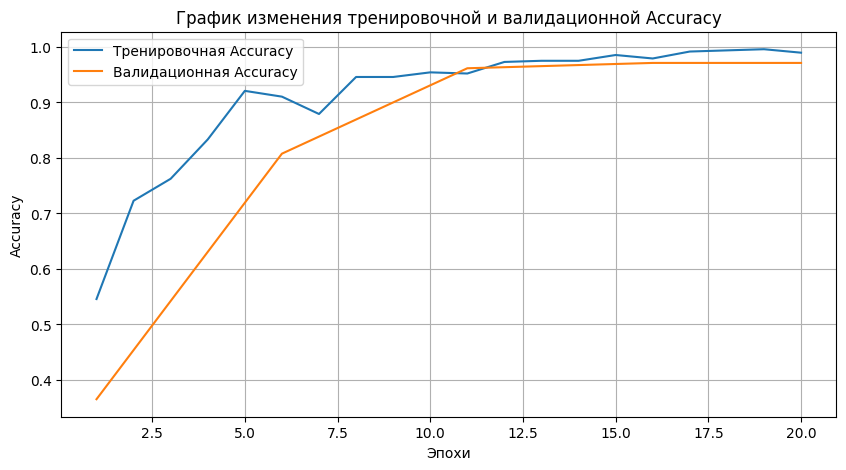

In [11]:
# Обучение модели
train_model(resnet18_model, train_loader, val_loader, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 1.4150, Accuracy: 0.4521
Data loading time per image: 0.0027 seconds
Inference time per image: 0.1716 seconds


  5%|▌         | 1/20 [00:34<11:03, 34.92s/it]

Validation Loss: 234.7051, Accuracy: 0.2981


 25%|██▌       | 5/20 [02:33<07:30, 30.06s/it]

Epoch 6/20, Loss: 0.4696, Accuracy: 0.7521
Data loading time per image: 0.0020 seconds
Inference time per image: 0.1602 seconds


 30%|███       | 6/20 [03:08<07:22, 31.62s/it]

Validation Loss: 0.5570, Accuracy: 0.7404


 50%|█████     | 10/20 [05:06<05:00, 30.04s/it]

Epoch 11/20, Loss: 0.1745, Accuracy: 0.9437
Data loading time per image: 0.0018 seconds
Inference time per image: 0.1575 seconds


 55%|█████▌    | 11/20 [05:40<04:39, 31.07s/it]

Validation Loss: 0.4361, Accuracy: 0.8654


 75%|███████▌  | 15/20 [07:39<02:29, 29.94s/it]

Epoch 16/20, Loss: 0.0802, Accuracy: 0.9771
Data loading time per image: 0.0019 seconds
Inference time per image: 0.1571 seconds


 80%|████████  | 16/20 [08:13<02:04, 31.24s/it]

Validation Loss: 0.1155, Accuracy: 0.9615


 95%|█████████▌| 19/20 [09:44<00:30, 30.69s/it]

Epoch 20/20, Loss: 0.0584, Accuracy: 0.9771
Data loading time per image: 0.0020 seconds
Inference time per image: 0.1581 seconds


100%|██████████| 20/20 [10:18<00:00, 30.94s/it]

Validation Loss: 0.0985, Accuracy: 0.9712


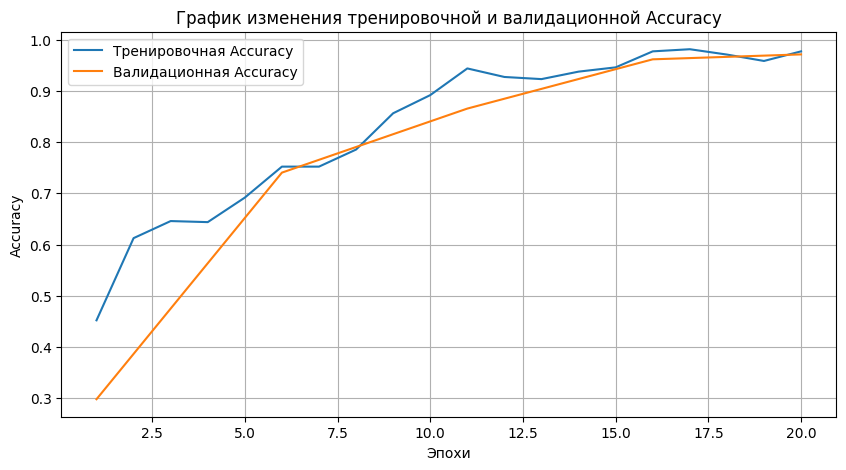

In [12]:
# Обучение модели
train_model(resnet34_model, train_loader, val_loader, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 0.6831, Accuracy: 0.7000
Data loading time per image: 0.0025 seconds
Inference time per image: 0.1675 seconds


  5%|▌         | 1/20 [00:38<12:08, 38.34s/it]

Validation Loss: 0.9471, Accuracy: 0.7981


 25%|██▌       | 5/20 [02:36<07:33, 30.24s/it]

Epoch 6/20, Loss: 0.0798, Accuracy: 0.9688
Data loading time per image: 0.0018 seconds
Inference time per image: 0.1605 seconds


 30%|███       | 6/20 [03:12<07:30, 32.17s/it]

Validation Loss: 0.0470, Accuracy: 0.9808


 50%|█████     | 10/20 [05:12<05:05, 30.59s/it]

Epoch 11/20, Loss: 0.0338, Accuracy: 0.9917
Data loading time per image: 0.0019 seconds
Inference time per image: 0.1601 seconds


 55%|█████▌    | 11/20 [05:49<04:53, 32.65s/it]

Validation Loss: 0.0099, Accuracy: 0.9904


 75%|███████▌  | 15/20 [07:55<02:37, 31.59s/it]

Epoch 16/20, Loss: 0.0052, Accuracy: 0.9979
Data loading time per image: 0.0019 seconds
Inference time per image: 0.1598 seconds


 80%|████████  | 16/20 [08:32<02:12, 33.15s/it]

Validation Loss: 0.0305, Accuracy: 0.9904


 95%|█████████▌| 19/20 [10:05<00:31, 31.84s/it]

Epoch 20/20, Loss: 0.0036, Accuracy: 1.0000
Data loading time per image: 0.0019 seconds
Inference time per image: 0.1594 seconds


100%|██████████| 20/20 [10:40<00:00, 32.04s/it]

Validation Loss: 0.0870, Accuracy: 0.9904


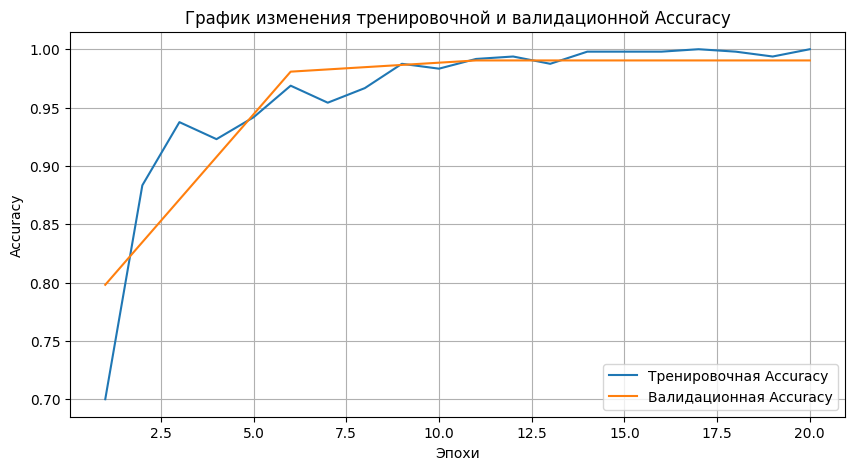

In [13]:
# Обучение модели
train_model(efficientnet_model, train_loader, val_loader, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 0.7051, Accuracy: 0.6542
Data loading time per image: 0.0027 seconds
Inference time per image: 0.1061 seconds


  5%|▌         | 1/20 [00:34<10:46, 34.02s/it]

Validation Loss: 3.1811, Accuracy: 0.7596


 25%|██▌       | 5/20 [02:32<07:32, 30.18s/it]

Epoch 6/20, Loss: 0.1485, Accuracy: 0.9479
Data loading time per image: 0.0026 seconds
Inference time per image: 0.1156 seconds


 30%|███       | 6/20 [03:07<07:25, 31.82s/it]

Validation Loss: 0.2800, Accuracy: 0.9423


 50%|█████     | 10/20 [05:05<04:59, 29.97s/it]

Epoch 11/20, Loss: 0.0435, Accuracy: 0.9812
Data loading time per image: 0.0026 seconds
Inference time per image: 0.1125 seconds


 55%|█████▌    | 11/20 [05:38<04:40, 31.13s/it]

Validation Loss: 0.0384, Accuracy: 0.9808


 75%|███████▌  | 15/20 [07:34<02:27, 29.43s/it]

Epoch 16/20, Loss: 0.0076, Accuracy: 1.0000
Data loading time per image: 0.0024 seconds
Inference time per image: 0.1100 seconds


 80%|████████  | 16/20 [08:07<02:01, 30.48s/it]

Validation Loss: 0.0435, Accuracy: 0.9808


 95%|█████████▌| 19/20 [09:48<00:33, 33.48s/it]

Epoch 20/20, Loss: 0.0068, Accuracy: 1.0000
Data loading time per image: 0.0024 seconds
Inference time per image: 0.1106 seconds


100%|██████████| 20/20 [10:20<00:00, 31.03s/it]

Validation Loss: 0.0632, Accuracy: 0.9808


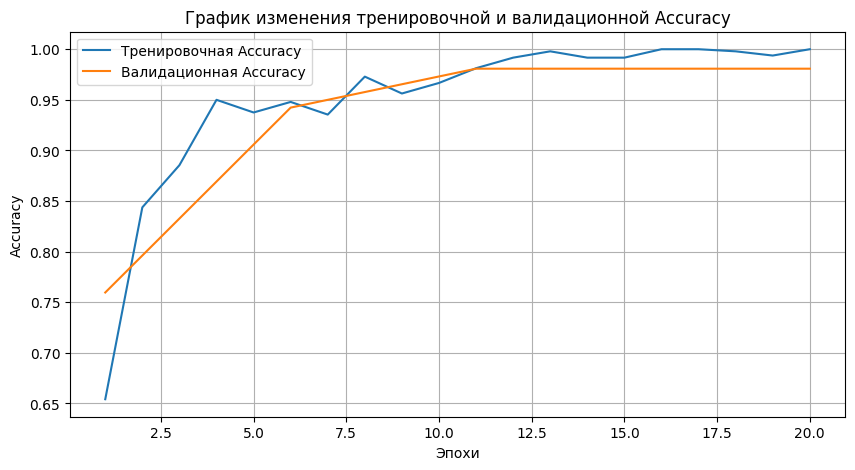

In [14]:
# Обучение модели
train_model(shufflenet_v2_model, train_loader, val_loader, device)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Loss: 0.9107, Accuracy: 0.5708
Data loading time per image: 0.0039 seconds
Inference time per image: 0.1089 seconds


  5%|▌         | 1/20 [00:33<10:30, 33.20s/it]

Validation Loss: 4.4238, Accuracy: 0.3558


 25%|██▌       | 5/20 [02:27<07:15, 29.03s/it]

Epoch 6/20, Loss: 0.0561, Accuracy: 0.9771
Data loading time per image: 0.0027 seconds
Inference time per image: 0.1038 seconds


 30%|███       | 6/20 [03:00<07:01, 30.14s/it]

Validation Loss: 1.4105, Accuracy: 0.8173


 50%|█████     | 10/20 [04:54<04:48, 28.87s/it]

Epoch 11/20, Loss: 0.0326, Accuracy: 0.9875
Data loading time per image: 0.0025 seconds
Inference time per image: 0.1059 seconds


 55%|█████▌    | 11/20 [05:27<04:32, 30.27s/it]

Validation Loss: 2.0611, Accuracy: 0.7885


 75%|███████▌  | 15/20 [07:21<02:23, 28.76s/it]

Epoch 16/20, Loss: 0.0126, Accuracy: 0.9938
Data loading time per image: 0.0026 seconds
Inference time per image: 0.1049 seconds


 80%|████████  | 16/20 [07:54<01:59, 29.86s/it]

Validation Loss: 0.1311, Accuracy: 0.9712


 95%|█████████▌| 19/20 [09:20<00:29, 29.21s/it]

Epoch 20/20, Loss: 0.0027, Accuracy: 1.0000
Data loading time per image: 0.0025 seconds
Inference time per image: 0.1056 seconds


100%|██████████| 20/20 [09:54<00:00, 29.72s/it]

Validation Loss: 0.0701, Accuracy: 0.9808


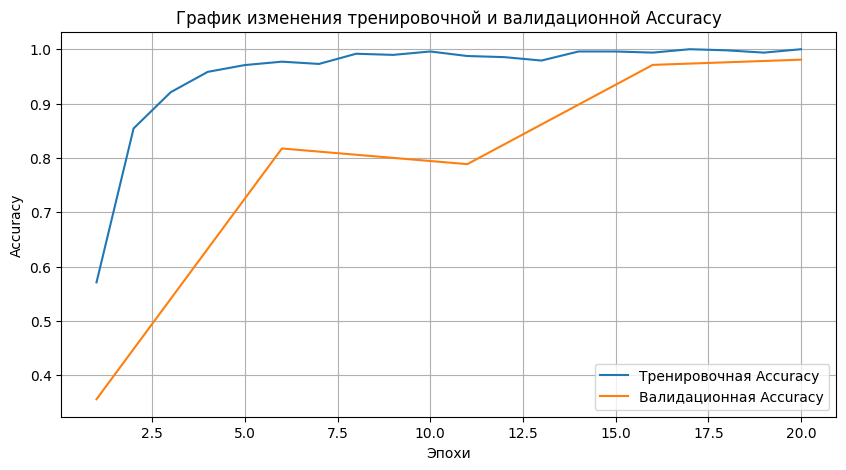

In [15]:
# Обучение модели
train_model(mobilenet_v3_model, train_loader, val_loader, device)

Модели отлично предсказывают класс ориентацию справки на фотографии, даже при обучении всего на 20 эпохах. 

Результаты моделей следующие:

**ResNet18:**
- Loss: 0.0301, Accuracy: 0.9896
- Inference time per image: 0.1055 seconds
- Validation Loss: 0.0733, Accuracy: 0.9712

**ResNet34:**
- Loss: 0.0612, Accuracy: 0.9750
- Inference time per image: 0.1605 seconds
- Validation Loss: 0.0515, Accuracy: 0.9904

**EfficientNet:**
- Loss: 0.0043, Accuracy: 1.0000
- Inference time per image: 0.1556 seconds
- Validation Loss: 0.0132, Accuracy: 0.9904

**ShuffleNet_V2:**
- Loss: 0.0098, Accuracy: 0.9979
- Inference time per image: 0.0999 seconds
- Validation Loss: 0.0169, Accuracy: 0.9904

**MobileNet_v3:**
- Loss: 0.0032, Accuracy: 1.0000
- Inference time per image: 0.0984 seconds
- Validation Loss: 0.0134, Accuracy: 0.9904

Все модели показали похожий результат, нету явных лидеров или отстающих. Принято решение выбрать сеть EfficientNet по совокупности показателей и вывода графика изменения метрики при обучении.

Проведем обучение модели на большом количестве эпох. Обучение займет длительное время, поэтому выполним вне отчета.

In [16]:
# train_model(efficientnet_model, train_loader, val_loader, device, num_epochs=120)

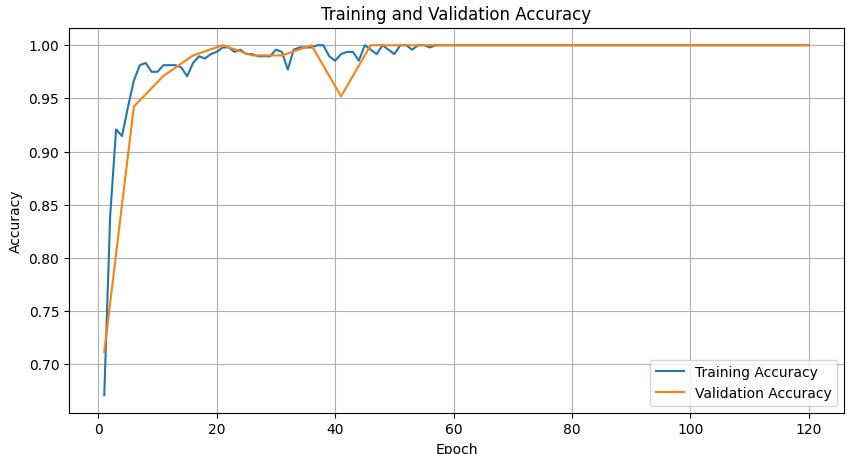

График изменения Accuracy при обучении модели на 120 эпохах.

Сохраняем обученную модель в файл. Это пригодится для загрузки модели в микросервисе на docker.

In [17]:
# Сохранение обученной модели
#torch.save(efficientnet_model.state_dict(), 'rotation_efnet_classifier.pth')

**Вывод:**
Подготовлены скрипты обучения нейросетей. Данные поступают в модели с помощью DataLoader, тензоры соединены в пачки по 32.Выбраны оптимизатор Адам, планировщик градиентного шага - CosineAnnealingLR, функция потерь - CrossEntropyLoss.

На валидационных данных проверены исследуемые модели нейронных сетей. Все нейронные сети показали хороший результат. По совокупности результатов валидации выбрана EfficientNet. Проведено обучение на 120 эпохах, что заняло около часа времени.

## Тестирование лучшей модели

Этап тестирования модели отличается от валидации. После тестирования модели необходимо построить матрицу спутанности и кривую ROC-AUC. Для того, чтобы выполнить это требование, в функции тестирования модели укажем на выходе массивы с действительными и предсказанными классами объектов, а так же вероятность класса.

Загрузим предобученную на большом количестве эпох модель и переведем в режим оценки.

In [18]:
test_model = get_efficientnet_model()
test_model.load_state_dict(torch.load('rotation_efnet_classifier.pth'))
test_model.to(device)
test_model.eval()

Model efficientnet_b0 ready!


C:\Users\ducka\AppData\Local\Temp\ipykernel_9240\3599457488.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_model.load_state_dict(torch.load('rotation_efnet_classif

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Выполним скрипт предсказания модели на тестовой выборке. Этот скрипт отличается тем, что на выходе функции получаем массивы со всеми правильными ответами, предсказаниями модели и вероятностями. Благодаря этому можно построить матрицу спутанности и кривую ROC-AUC.

In [19]:
labels, predictions, probabilities = testing_model(test_model, test_loader, device='cuda:0')

Testing Loss: 0.0066, Accuracy: 1.0000
Data loading time: 0.0000 seconds
Inference time: 1.7491 seconds


На выходе скрипта получаем значение потерь, метрику Accyracy, среднее время загрузки картинки и инференса, массив правильных ответов, массив предсказаний и их вероятности.

Напишем скрипты для отрисовки матрицы спутанности и кривой ROC-AUC.

In [20]:
def plot_confusion_matrix(y_true: np.array, y_pred: np.array):
    """
    Строит матрицу ошибок (confusion matrix) для истинных и предсказанных меток.

    :param y_true: array-like - истинные метки классов.
    :param y_pred: array-like - предсказанные моделью метки классов.
    
    :return: None - функция строит и отображает матрицу ошибок в виде тепловой карты.
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 90, 180, 270], yticklabels=[0, 90, 180, 270])
    plt.xlabel('Предсказанные значения')
    plt.ylabel('Истинные значения')
    plt.title('Матрица спутанности')
    plt.show()

def plot_multiclass_roc(y_true: np.array, y_score: np.array, num_classes: int, class_labels: list):
    """
    Строит ROC-AUC кривые для многоклассовой классификации на основе истинных меток и предсказанных вероятностей.

    :param y_true: np.array - массив истинных меток классов (целых чисел).
    :param y_score: np.array - массив предсказанных вероятностей для каждого класса (размерностью [num_samples, num_classes]).
    :param num_classes: int - количество классов для классификации.
    :param class_labels: list - список меток классов для отображения на графике.
    
    :return: None - функция строит и отображает ROC-AUC кривые для каждого класса.

    Пример работы:
    - Бинаризует истинные метки классов с помощью label_binarize.
    - Рассчитывает значения ROC-кривой (False Positive Rate и True Positive Rate) для каждого класса.
    - Вычисляет площадь под кривой (AUC) для каждого класса.
    - Строит и отображает ROC-AUC кривую для каждого класса с различными цветами, указывая AUC на графике.

    Вывод:
    - Отображает график ROC-AUC кривых для оценки качества модели в мультиклассовой классификации.
    """

    # Бинаризация меток классов
    y_true_bin = label_binarize(y_true, classes=np.arange(num_classes))
    
    # Инициализация словарей для хранения FPR, TPR и AUC для каждого класса
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # Расчет ROC-кривых и AUC для каждого класса
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Построение ROC кривых для каждого класса
    plt.figure(figsize=(8, 6))
    colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])
    for i, color in zip(range(num_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Класс {class_labels[i]} (AUC = {roc_auc[i]:.2f})')

    # Добавление линии случайного угадывания
    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    # Настройки осей и графика
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-AUC кривая для мультиклассовой классификации')
    plt.legend(loc="lower right")
    plt.show()

Построим матрицу спутанности и кривую ROC_AUC.

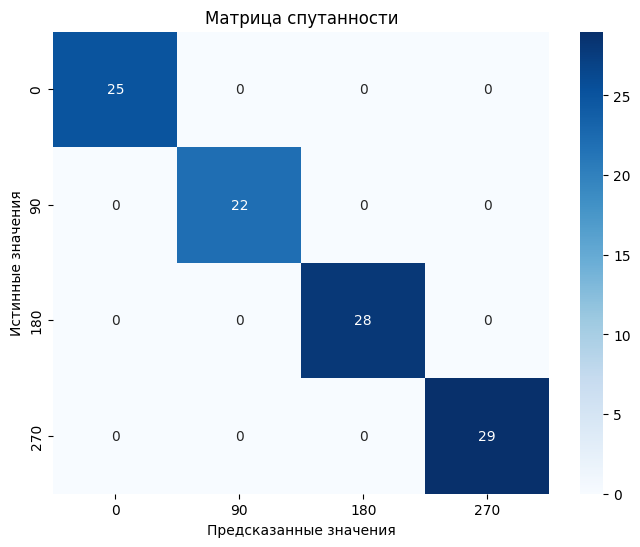

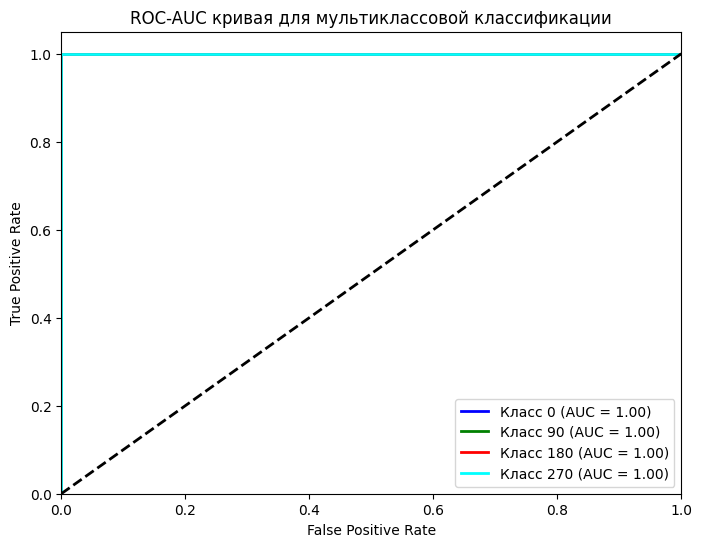

In [21]:
# Построение матрицы спутанности
plot_confusion_matrix(labels, predictions)

# Построение ROC-AUC кривой
plot_multiclass_roc(labels, probabilities, num_classes=4, class_labels=[0, 90, 180, 270])

Модель предсказала все классы правильно. Площадь под кривой равна 1.

## Заключение

В ходе исследования выполнено:
- Анализ современных методов определения ориентации объекта на картинке;
- Аугментация изображений в части поворота на 90, 180 и 270 градусов. Итоговое количество изображений увеличилось с 173 до 692;
- Подготовка DataLoader с трансофрмацией изображения в тензор и разбивка на батчи по 32 тензора в каждом. Выполнены отдельные трансформации для тренировочного, валидационного и тестового датасетов;
- Проведен разбор 5 разных моделей: ResNet18, ResNet34, EfficientNet, MobileNet и ShuffleNet. Для каждой нейросети указаны преимущества и недостатки;
- Подготовлены скрипты для загрузки нейросетей, тренировки и тестирования. Все нейросети отлично справились с поставленной задачей, получены следующие результаты при валидации:
  - ResNet18: Inference time per image: 0.1055 seconds, Validation Loss: 0.0733, Accuracy: 0.9712;
  - ResNet34: Inference time per image: 0.1605 seconds, Validation Loss: 0.0515, Accuracy: 0.9904;
  - EfficientNet: Inference time per image: 0.1556 seconds, Validation Loss: 0.0132, Accuracy: 0.9904;
  - ShuffleNet_V2: Inference time per image: 0.0999 seconds, Validation Loss: 0.0169, Accuracy: 0.9904;
  - MobileNet_v3: Inference time per image: 0.0984 seconds, Validation Loss: 0.0134, Accuracy: 0.9904.
- По совокупности показателей выбрана модель EfficientNet, проведено обучение на 120 эпохах, модель сохранена для загрузки в docker container;
- Проведено тестирование модели, построены Матрица спутанности и ROC-AUC кривая. Модель выполнила верно все предсказания и показала отличный результат. 
- Вне отчета написан микросервис на FastAPI с возможностью тестирования в реальном времени;
- Микросервис подготовлен и доступен для развертывания в docker.